In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

torch.set_default_device("cuda")

In [161]:
########### MODEL CLASSES ###############


class NormalizationLayer(nn.Module):
    def __init__(self, maxnorm, input_shape):
        super(NormalizationLayer, self).__init__()
        self.maxnorm = maxnorm
        self.weight = torch.nn.Parameter(data=torch.randn(input_shape),requires_grad=True)
        self.sigmoid = nn.Sigmoid()
        self.a = torch.nn.Parameter(data=torch.randn(input_shape[0],1), requires_grad=True)
        
        
    def forward(self, inputs):
        output = inputs * (self.weight / torch.norm(self.weight, dim=1, p=2, keepdim=True)) * self.maxnorm * self.sigmoid(self.a)
        return output
    
class NoiseLayer(nn.Module):
    def __init__(self, noise_radius):
        super(NoiseLayer, self).__init__()
        self.noise_radius = noise_radius
        self.alpha = 0.5
        self.beta = 0.5
        
    def spherical_gaussian(self, num_circles):
        x = torch.randn(num_circles, 2)
        beta_distribution = torch.distributions.Beta(self.alpha, self.beta)
        u = beta_distribution.sample((num_circles,2))
        norm = torch.norm(x, dim=1, keepdim=True, p=2)
        noise = x * (u) * self.noise_radius / norm
        return noise

    def forward(self, inputs, alpha, beta):
        self.alpha = alpha
        self.beta = beta
        noise = self.spherical_gaussian(inputs.size(0))
        return inputs + noise
    

class EncoderDecoder(nn.Module):
    def __init__(self, num_circles, larger_radius, smaller_radius):
        super(EncoderDecoder, self).__init__()
        
        self.main_dim = num_circles
        self.latent_dim = 2
        self.R = larger_radius
        self.r = smaller_radius
        self.mid_dim = 300
        self.alpha = 0.5

        self.normalize = NormalizationLayer(self.R - self.r, (num_circles, 2))       
        self.noise = NoiseLayer(self.r)
        
        self.encoder = nn.Sequential(
            nn.Linear(self.main_dim, self.mid_dim),
            nn.SELU(),
            nn.Linear(self.mid_dim, self.main_dim),
            nn.SELU(),
            nn.Linear(self.main_dim, self.latent_dim),
            nn.Tanh()
        )       
        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dim, self.main_dim),
            nn.ReLU(),
            nn.Linear(self.main_dim, self.mid_dim),
            nn.ReLU(),
            nn.Linear(self.mid_dim, self.main_dim),
            nn.Softmax(dim=1)
        )
        
    def forward(self, x, alpha, beta):
        encoded = self.encoder(x)
        normed_encoded = self.normalize(encoded)
        noisy_encoded = self.noise(normed_encoded, alpha, beta)
        decoded = self.decoder(noisy_encoded)
        return decoded

    def regions(self, x, alpha, beta, colors):
        with torch.no_grad():
            encoded = self.encoder(x)
            normal_encoded = self.normalize(encoded)
            noisy_encoded = self.noise(normal_encoded, alpha, beta)
            decoded = self.decoder(noisy_encoded).cpu()
            noisy_encoded = noisy_encoded.cpu()
            # Generate a list of unique colors for each label

            # Plotting the data
            for i in range(noisy_encoded.shape[0]):
                label_index = int(np.argmax(decoded[i]))
                plt.scatter(noisy_encoded[i, 0], noisy_encoded[i, 1], color=colors(label_index), label=f'Class {label_index}')
                plt.annotate("guess"+str(label_index), (noisy_encoded[i, 0], noisy_encoded[i, 1]), fontsize=8, ha='center', va='bottom')
            
            # Adding a legend (only one entry per class)
            #handles, labels = plt.gca().get_legend_handles_labels()
            #by_label = dict(zip(labels, handles))
            #plt.legend(by_label.values(), by_label.keys())
            plt.xlabel('X-axis')
            plt.ylabel('Y-axis')
            plt.title('2D Coordinates with Different Colors')
            plt.show()
        return 0

    def centres(self, x):
        return self.normalize(self.encoder(x)).cpu().detach().numpy()

In [180]:
def one_hot(a, num_classes):
    return torch.tensor(np.eye(num_classes)[a], dtype=torch.float32)

In [203]:
def plot_circles_2(centres, large_radius, small_radius, colors, save = False, savename=None):
    fig = plt.figure(figsize=(10, 10))
    ax = plt.gca()
    ax.axis('off')
    ax.add_patch(plt.Circle((0,0), radius = large_radius, fill = False, linewidth = 2.0, color = 'black'))
    ax.axis('scaled')
    for rad, centre in enumerate(centres):
        (x,y) = centre
        ax.add_patch(plt.Circle(centre, radius = small_radius, fill = False, linewidth = 1.0, color = colors(rad)))
        ax.annotate(str(rad), (x, y), (x, y), fontsize=12, ha='center', va='center')
    if save:
        plt.savefig(savename)


In [182]:
def plot_circles(centres, large_radius, small_radius, save = False, savename=None):
    fig, ax = plt.subplots(figsize = (2, 2))
    ax.axis('off')
    ax.scatter(0,0, color = 'red')
    ax.add_patch(plt.Circle((0,0), radius = large_radius, fill = False, linewidth = 2.0, color = 'black'))
    ax.axis('scaled')
    for rad, centre in enumerate(centres):
        (x,y) = centre
        #ax.annotate(str(rad+1), (x,y), (x,y), fontsize = 16)
        ax.add_patch(plt.Circle(centre, radius = small_radius, fill = False, linewidth = 1.0, color = 'blue'))
    if save:
        plt.savefig(savename)
    plt.show()

def packing_density(centres, r, R = 1, NumSamples = 100000):
    '''
    centres: centres of the spheres [N,2], N: Number of spheres
    r: radius of each circle
    R: radius of enclosing circle
    NumSamples: number of points to be sampled towards density calculation
    '''
    x = np.random.normal(size=[NumSamples, 2])
    u = np.random.uniform(size=[NumSamples, 1])
    norm = np.linalg.norm(x, axis = 1, keepdims=True)

    #these points are distributed uniformly inside the circle
    coordinates = x*np.power(u, 1/2)/norm*R
    
    centres_reshaped = np.reshape(centres, [1, centres.shape[0], centres.shape[1]])
    coordinates_reshaped = np.reshape(coordinates, [coordinates.shape[0], 1, coordinates.shape[1]])
    distances_from_centres = np.linalg.norm(coordinates_reshaped - centres_reshaped, axis = 2)
    min_distances = np.min(distances_from_centres, axis = 1)
        
    return np.sum(min_distances < r)/NumSamples

  0%|          | 0/2000 [00:00<?, ?it/s]

Epcoh 0
Packing Density : 0.4267


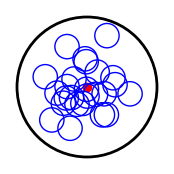

  0%|          | 1/2000 [00:01<58:07,  1.74s/it]

##########################


  5%|▌         | 100/2000 [02:25<44:04,  1.39s/it]

Epcoh 100
Packing Density : 0.62355


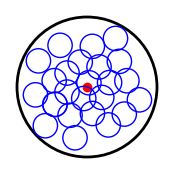

  5%|▌         | 101/2000 [02:26<45:38,  1.44s/it]

##########################


 10%|█         | 200/2000 [04:47<46:57,  1.57s/it]

Epcoh 200
Packing Density : 0.66093


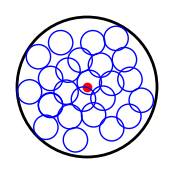

 10%|█         | 201/2000 [04:49<48:42,  1.62s/it]

##########################


 15%|█▌        | 300/2000 [07:03<41:07,  1.45s/it]

Epcoh 300
Packing Density : 0.66926


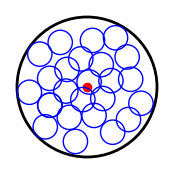

 15%|█▌        | 301/2000 [07:05<43:48,  1.55s/it]

##########################


 20%|██        | 400/2000 [09:37<41:07,  1.54s/it]

Epcoh 400
Packing Density : 0.67668


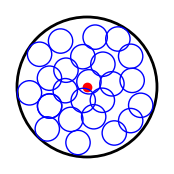

 20%|██        | 401/2000 [09:39<42:22,  1.59s/it]

##########################


 25%|██▌       | 500/2000 [12:12<36:25,  1.46s/it]

Epcoh 500
Packing Density : 0.68338


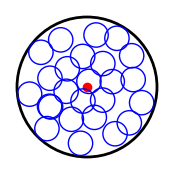

 25%|██▌       | 501/2000 [12:14<37:23,  1.50s/it]

##########################


 30%|███       | 600/2000 [14:41<33:14,  1.42s/it]

Epcoh 600
Packing Density : 0.6941


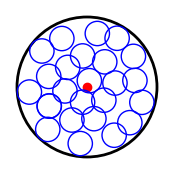

 30%|███       | 601/2000 [14:43<34:49,  1.49s/it]

##########################


 35%|███▌      | 700/2000 [17:10<31:58,  1.48s/it]

Epcoh 700
Packing Density : 0.70331


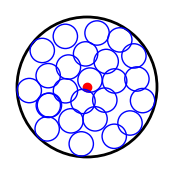

 35%|███▌      | 701/2000 [17:12<33:08,  1.53s/it]

##########################


 40%|████      | 800/2000 [19:38<29:10,  1.46s/it]

Epcoh 800
Packing Density : 0.71145


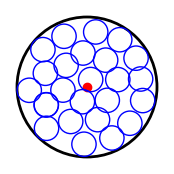

 40%|████      | 801/2000 [19:40<30:55,  1.55s/it]

##########################


 44%|████▍     | 876/2000 [21:33<27:39,  1.48s/it]


KeyboardInterrupt: 

In [183]:
# Parameters
num_circles = 25 #127
large_radius = 1.0
small_radius = 0.173827661421222233359259594413
#small_radius = 	#0.080246842401966631917112929101
BATCHES = 200
EPOCHS = 2000
DEVICE = "cuda"

# Initialize input data and loss function
eye = one_hot(np.arange(0, num_circles), num_circles)
Input = eye.repeat(BATCHES, 1, 1).to(DEVICE)

model = EncoderDecoder(num_circles, large_radius, small_radius).to(DEVICE)


loss = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=0.0005)
optim2 = torch.optim.Adam(model.parameters(), lr=0.00005)
optim3 = torch.optim.Adam(model.parameters(), lr=0.000005)
alpha = 2
beta = 8
loss_list = []
# Training loop
for epoch in tqdm(range(EPOCHS)):
    if epoch == 300 :
        alpha = 2
        beta = 8
    if epoch == 500 :
        alpha = 4
        beta = 8
    if epoch == 700 :
        alpha = 4
        beta = 4
    if epoch == 800 :
        alpha = 1
        beta = 1
    epoch_loss = 0
    if epoch < 2000:
        for inputs in Input:           
            optim.zero_grad()
            outputs = model(inputs, alpha, beta)
            curr_loss = loss(outputs, inputs.argmax(dim=1))
            curr_loss.backward()
            optim.step()
            epoch_loss += curr_loss.detach().cpu()
    # if epoch >= 4000 and epoch < 7000:
    #     for inputs in Input: 
    #         optim2.zero_grad()
    #         outputs = model(inputs, alpha, beta)
    #         curr_loss = loss(outputs, inputs.argmax(dim=1))
    #         curr_loss.backward()
    #         optim2.step()
    #         epoch_loss += curr_loss.detach().cpu()
    # if epoch >= 7000:
    #     for inputs in Input: 
    #         optim3.zero_grad()
    #         outputs = model(inputs, alpha, beta)
    #         curr_loss = loss(outputs, inputs.argmax(dim=1))
    #         curr_loss.backward()
    #         optim3.step()
    #         epoch_loss += curr_loss.detach().cpu()
    loss_list.append(epoch_loss)
    if epoch % 100 == 0:
        print(f"Epcoh {epoch}") 
        centres = model.centres(eye)
        print(f"Packing Density : {packing_density(centres, small_radius, large_radius)}")
        # print(f"Circle Config : ")
        plot_circles(centres, large_radius, small_radius)
        print("##########################")

centres = model.centres(eye)
plot_circles(centres, large_radius, small_radius)

In [197]:
from matplotlib.colors import ListedColormap, to_rgba_array

# Example list of 25 hex color values
hex_colors = [
    '#dcdcdc', '#8b4513', '#708090', '#808000', '#483d8b',
    '#3cb371', '#000080', '#9acd32', '#8b008b', '#48d1cc',
    '#ff4500', '#ffa500', '#ffff00', '#00ff00', '#8a2be2',
    '#00ff7f', '#00bfff', '#0000ff', '#ff00ff', '#1e90ff',
    '#db7093', '#f0e68c', '#ff1493', '#ffa07a', '#ee82ee',
]

# Convert hex colors to RGBA format
rgba_colors = [to_rgba_array(color) for color in hex_colors]

# Create ListedColormap
custom_cmap = ListedColormap(rgba_colors, name='custom_cmap')

THIS IS WHAT ENCODER LEARNS TO DO
This is regions in decoder


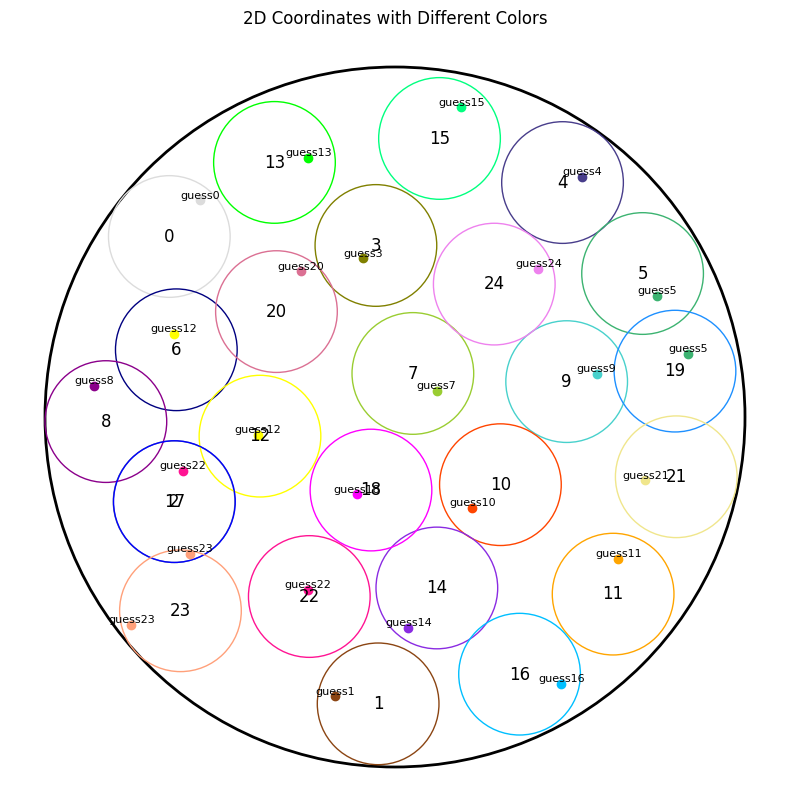

0

In [204]:
print("THIS IS WHAT ENCODER LEARNS TO DO") 
centres = model.centres(eye)
colors = custom_cmap
plot_circles_2(centres, large_radius, small_radius, colors, save=False)
print("This is regions in decoder")
model.regions(eye, alpha, beta, colors)

THIS IS WHAT ENCODER LEARNS TO DO
Packing Density : 0.49734
Centers :


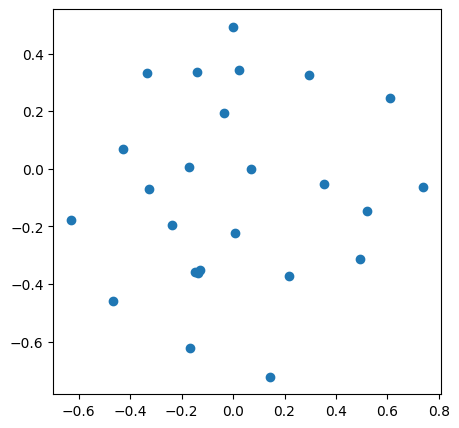

Circle Config : 


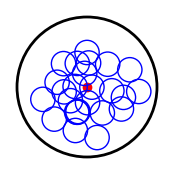

##########################


In [68]:
print("THIS IS WHAT ENCODER LEARNS TO DO") 
centres = model.centres(eye)
print(f"Packing Density : {packing_density(centres, small_radius, large_radius)}")
print(f"Centers :")
plt.figure(figsize=(5,5))
plt.scatter(centres[:,0], centres[:,1])
plt.show()
print(f"Circle Config : ")
plot_circles(centres, large_radius, small_radius)
print("##########################")

In [ ]:
# ########### MODEL CLASSES ###############


# class NormalizationLayer(nn.Module):
#     def __init__(self, maxnorm, input_shape):
#         super(NormalizationLayer, self).__init__()
#         self.maxnorm = maxnorm
#         self.weight = torch.nn.Parameter(data=torch.randn(input_shape),requires_grad=True)
#         self.sigmoid = nn.Sigmoid()
#         self.a = torch.nn.Parameter(data=torch.randn(input_shape[0],1), requires_grad=True)
        
        
#     def forward(self, inputs):
#         output = inputs * (self.weight / torch.norm(self.weight, dim=1, p=2, keepdim=True)) * self.maxnorm * self.sigmoid(self.a)
#         return output
    
# class NoiseLayer(nn.Module):
#     def __init__(self, noise_radius):
#         super(NoiseLayer, self).__init__()
#         self.noise_radius = noise_radius
#         self.alpha = 0.5
        
#     def spherical_gaussian(self, num_circles):
#         x = torch.randn(num_circles, 2)
#         u = torch.rand(num_circles, 1)
#         norm = torch.norm(x, dim=1, keepdim=True, p=2)
#         noise = x * (u.pow(self.alpha)) * self.noise_radius / norm
#         return noise

#     def forward(self, inputs, alpha):
#         self.alpha = alpha
#         noise = self.spherical_gaussian(inputs.size(0))
#         return inputs + noise
    

# class EncoderDecoder(nn.Module):
#     def __init__(self, num_circles, larger_radius, smaller_radius):
#         super(EncoderDecoder, self).__init__()
        
#         self.main_dim = num_circles
#         self.latent_dim = 2
#         self.R = larger_radius
#         self.r = smaller_radius
#         self.mid_dim = 30
#         self.alpha = 0.5

#         self.normalize = NormalizationLayer(self.R - self.r, (num_circles, 2))       
#         self.noise = NoiseLayer(self.r)
        
#         self.encoder = nn.Sequential(
#             nn.Linear(self.main_dim, self.mid_dim),
#             nn.SELU(),
#             nn.Linear(self.mid_dim, self.main_dim),
#             nn.SELU(),
#             nn.Linear(self.main_dim, self.latent_dim),
#             nn.Tanh()
#         )       
#         self.decoder = nn.Sequential(
#             nn.Linear(self.latent_dim, self.main_dim),
#             nn.ReLU(),
#             nn.Linear(self.main_dim, self.mid_dim),
#             nn.ReLU(),
#             nn.Linear(self.mid_dim, self.main_dim),
#             nn.Softmax(dim=1)
#         )
        
#     def forward(self, x, alpha):
#         self.alpha = alpha
#         encoded = self.encoder(x)
#         normed_encoded = self.normalize(encoded)
#         noisy_encoded = self.noise(normed_encoded, alpha)
#         decoded = self.decoder(noisy_encoded)
#         return decoded

#     def centres(self, x):
#         return self.normalize(self.encoder(x)).detach().numpy()